<center><font size=5>单因子示例</font></center>

目前只有IC相关的计算。余下的有待大家探索。

加载各种包

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # 文件位于

import factors  # 因子计算
import data_utils  # 数据读取
import performance as perf  # IC计算
import plotting  #绘图

# 1. 初始化DataLoader 

DataLoader实现了对csv文件的批量读取，会按照\[年\]\[月\]保存在dl中。
一些重要函数：
- init_month_df: 加载目标文件夹下的所有zip文件。这些文件读取后会被保存在dataloader中。注意，目前默认读取binance的k line格式的数据。具体见data_utils.py.
    - :param root_path: 根文件夹
    - 可以通过dataloader.get_month_df() 取出。(<font color=red>注意，每个月是一个list，里面有多个df</font>)
  
- compute_future_rtn_for_all: 给DataLoader中的每个DF计算未来收益率 fwd_rtn_N 。添加到对应df中作为一列。
    - periods=(5, 10, 20, 50, 100)，1默认计算
    - fwd_rtn_N：未来收益率 (N替换为时间长度)
    - fwd_rtn_N_real：未来真实收益率，除去了不同资产收益率方差的影响。


In [2]:
root_path = '../../data/15m_data/'  # 存放数据的路径
dl = data_utils.DataLoader()
dl.init_month_df(root_path)
# 计算未来收益率
data_utils.compute_future_rtn_for_all(dl)

In [3]:
import pandas as pd
import numpy as np
from pandas_ta.core import adx, cci, macd, rsi, obv, vwap, atr, bop, ohlc4

## 2. 自定义因子计算函数

需要自定义一个因子计算function，输入输出都是同一个DataFrame即可。（自己定义的因子作为一个新的列，加入到原本df中）。这里给了个案例，添加了一个‘macd’因子，此处的列名称就是后续计算的因子名称。

装饰器<font color=orange> @factors.handle_dataloader_data</font> 的作用是，使得这个函数能够用在dl的全部数据里，详见 <font color=lightblue>factors.handle_dataloader_data]</font>

ps.目前默认的因子计算只提供了几个。总体而言，基于pandas_ta进行因子计算就行。

In [4]:
@factors.handle_dataloader_data
def add_new_factor(raw_df:pd.DataFrame, **kwargs)-> pd.DataFrame:
    '''
    加入新因子的模板。
    :param raw_df: 原始数据
    :param factor_name: 因子名称
    :return: 原始数据+因子
    '''
    raw_df['macd'] = macd(raw_df['close'])['MACD_12_26_9']
    return raw_df

In [5]:
# 计算因子
add_new_factor(dl)

## 3. 查看结果

- cal_monthly_mean_ic：按照月去计算每个月平均IC（每个月由很多个资产各自的DF组成，先计算各自的IC，再求平均）。
- set_record_df：保存，本质是字典
    - kind = \[Info, SingelML, ALLMl \] 目前我们计算的都是Info，其他还在开发中。
- plot_information_table：展示df
- plot_ic_qq: qq plot
- plot_ic_ts：IC均值
- plot_ic_hist：直方图

Information Analysis


,fwd_rtn_1_real,fwd_rtn_5_real,fwd_rtn_10_real,fwd_rtn_20_real,fwd_rtn_50_real,fwd_rtn_100_real
IC Mean,-0.032,-0.067,-0.095,-0.121,-0.130,-0.139
IC Std.,0.011,0.019,0.024,0.031,0.044,0.050
Risk-Adjusted IC,-2.860,-3.442,-3.941,-3.880,-2.973,-2.776
t-stat(IC),-19.186,-23.092,-26.438,-26.025,-19.943,-18.619
p-value(IC),0.000,0.000,0.000,0.000,0.000,0.000
IC Skew,0.594,0.495,0.404,0.392,0.630,0.258
IC Kurtosis,-0.148,-0.325,-0.519,-0.763,-0.115,-0.383


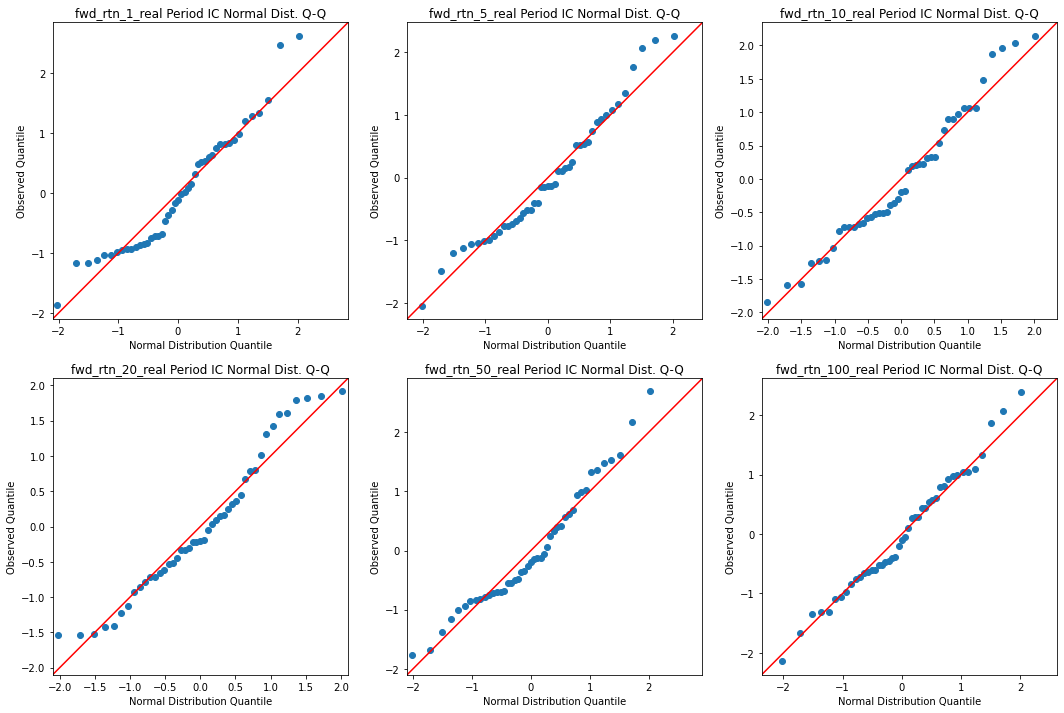

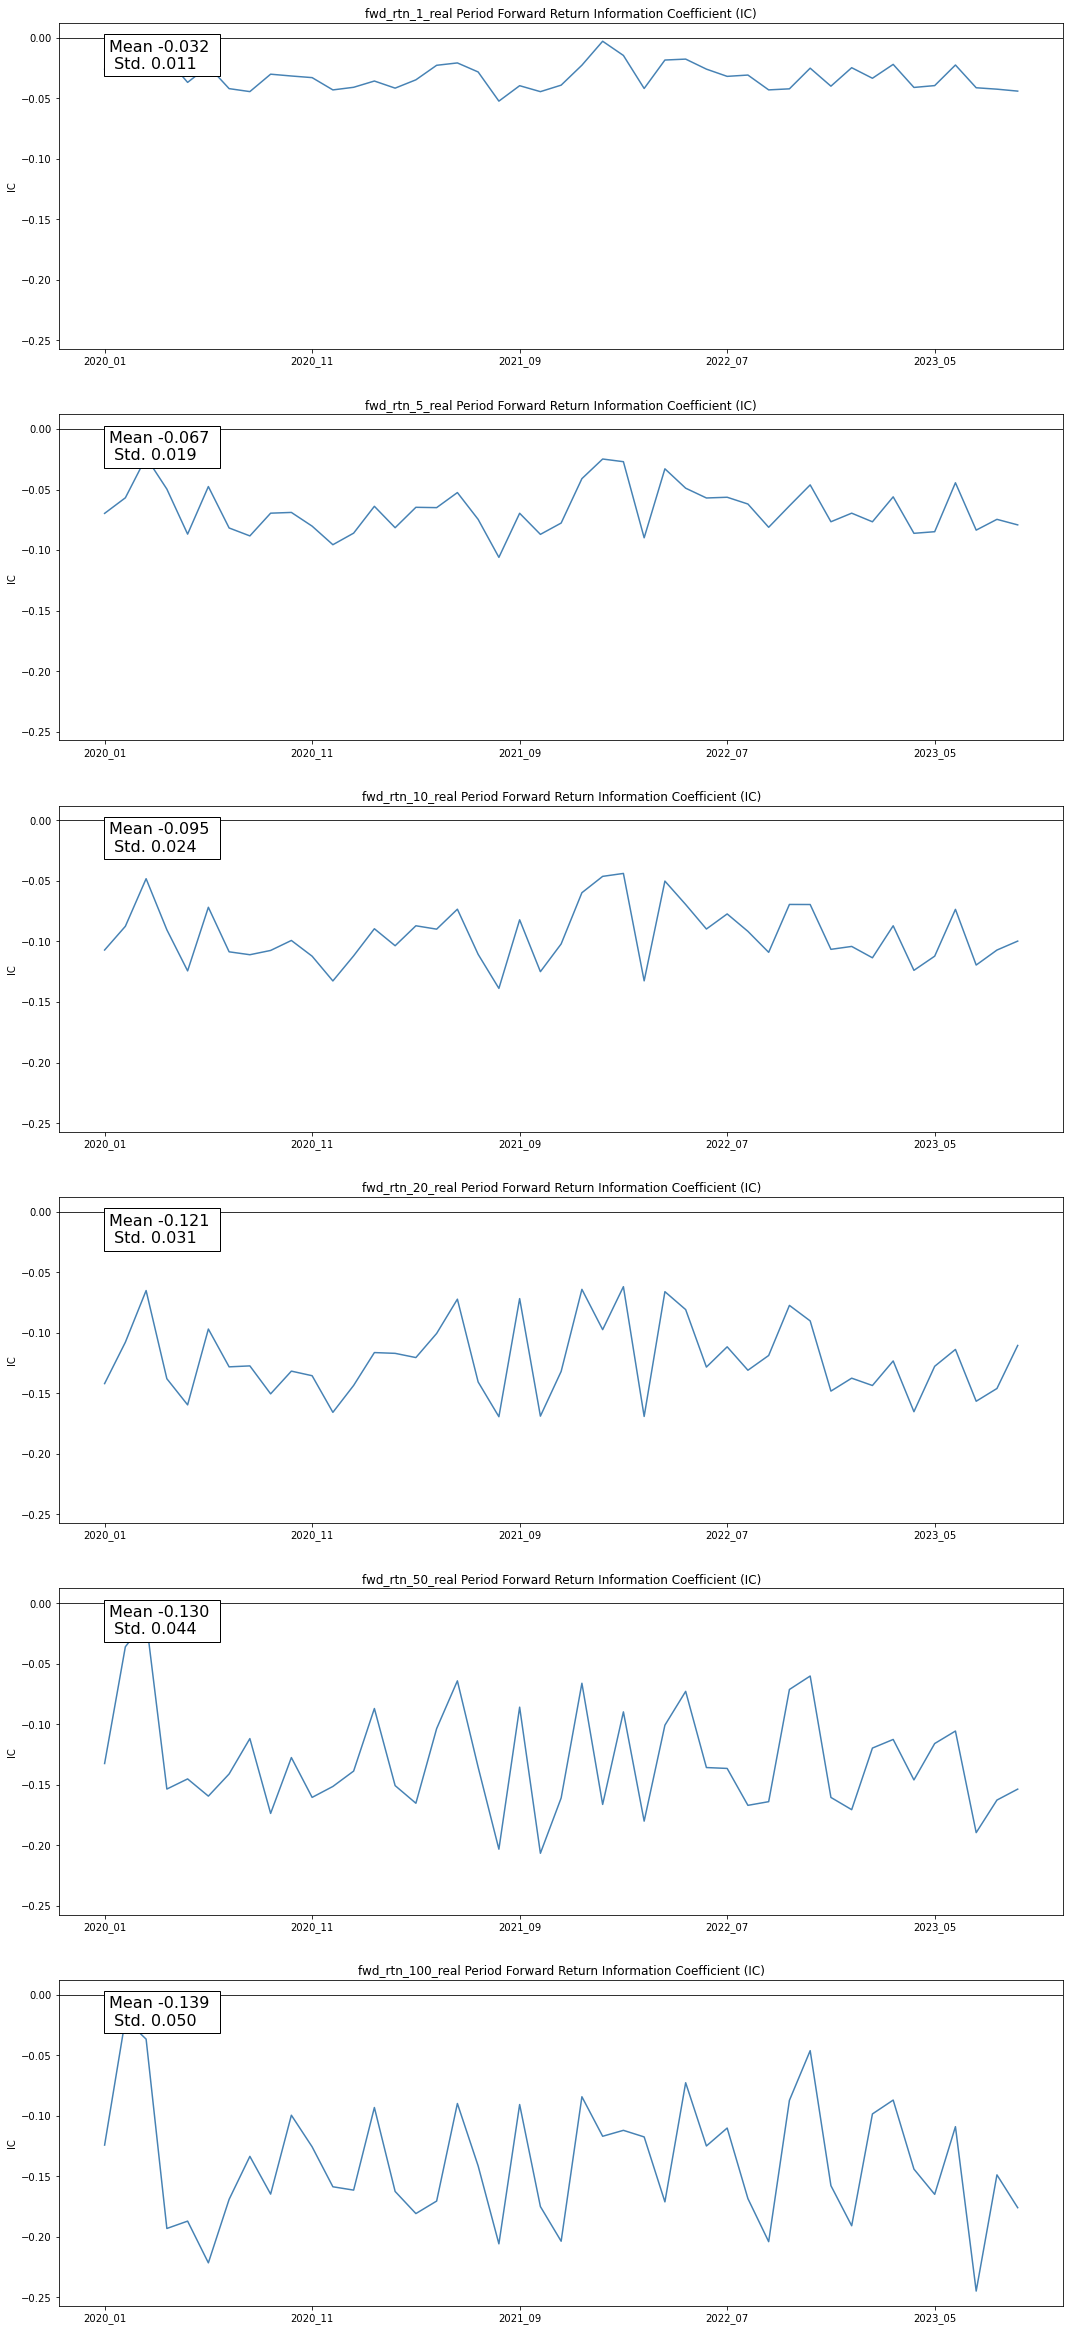

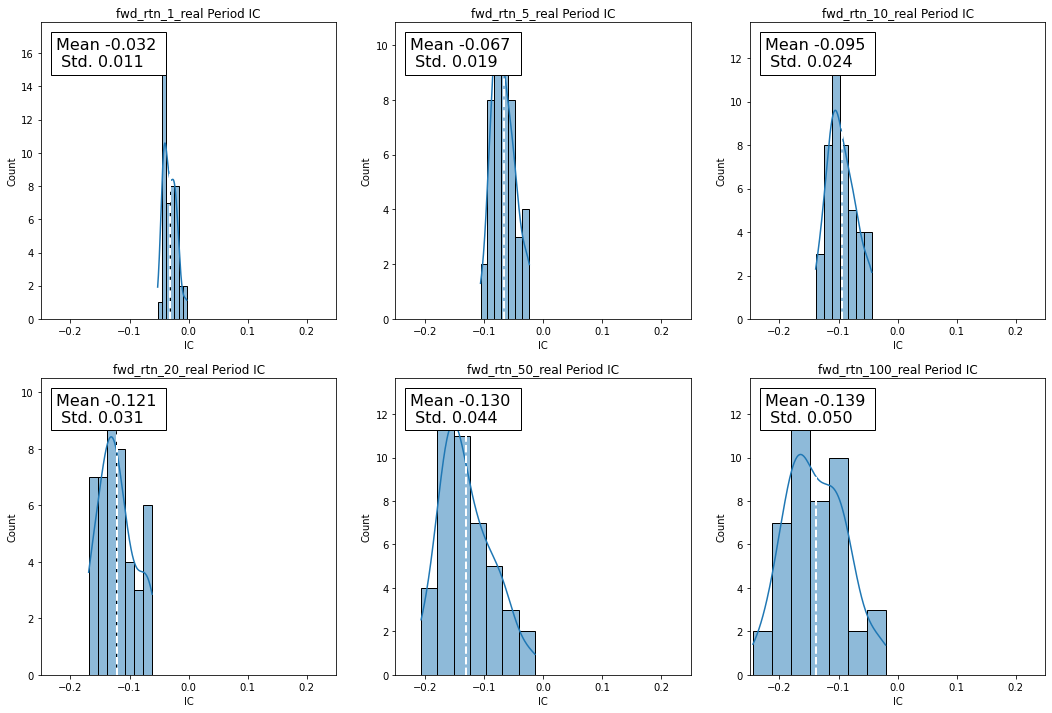

In [6]:
tests_factor_name='macd'
print(f'Factor: {tests_factor_name}')
month_mean_ic = perf.cal_monthly_mean_ic(dl, factor_name=tests_factor_name, use_real_rtn=True)
# 保存记录
dl.set_record_df(kind='Info', factor_name=tests_factor_name, result_df=month_mean_ic)
# 读取记录，并且展示作图
month_mean_ic = dl.get_record_df(kind='Info', factor_name=tests_factor_name)
plotting.plot_information_table(month_mean_ic)
plotting.plot_ic_qq(month_mean_ic)
plotting.plot_ic_ts(month_mean_ic)
plotting.plot_ic_hist(month_mean_ic)
plt.show()